In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 


sns.set_style('darkgrid')
sns.set_palette('husl')


pd.set_option('display.max_rows', 100 )
warnings.filterwarnings("ignore")

In [2]:
df_iris = sns.load_dataset('iris')
df_iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [3]:
labels_dict = {
    'setosa' : '1',
    'versicolor' : '2',
    'virginica' : '0'
}

df_iris_by_species = df_iris.replace(labels_dict).groupby(['species'])
df_iris_by_species.groups.keys()


dict_keys(['0', '1', '2'])

In [4]:
df_iris_by_species.mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
0,6.588,2.974,5.552,2.026
1,5.006,3.428,1.462,0.246
2,5.936,2.770,4.260,1.326


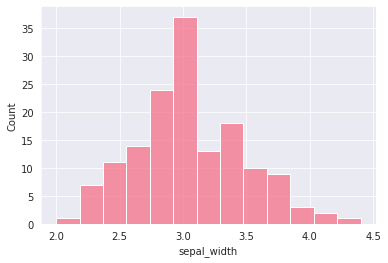

In [5]:
sns.histplot(data=df_iris, x="sepal_width")

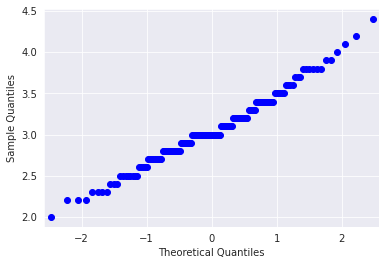

In [23]:
import statsmodels.api as sm
sm.qqplot(df_iris.sepal_width)
plt.show()


In [6]:
import scipy.stats

scipy.stats.shapiro(df_iris['sepal_width'])

ShapiroResult(statistic=0.9849170446395874, pvalue=0.10113201290369034)

La prueba de Shapiro-Wilk muestra un valor p de 0.10, que es superior a 0.05, lo que sugiere que los datos están distribuidos normalmente. En resumen, si el valor p de Shapiro-Wilk es superior a 0.05, sugiere que los datos son normales y si es inferior a 0.05, entonces no son normales.

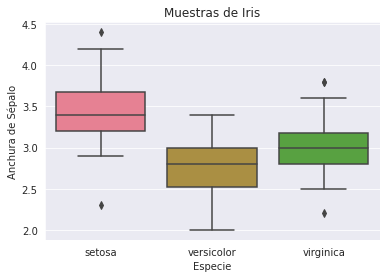

In [7]:
fig, ax = plt.subplots()
sns.boxplot(data=df_iris, 
            y="sepal_width",
            x="species")
ax.set(xlabel="Especie",
       ylabel="Anchura de Sépalo",
       Title="Muestras de Iris")

plt.show()

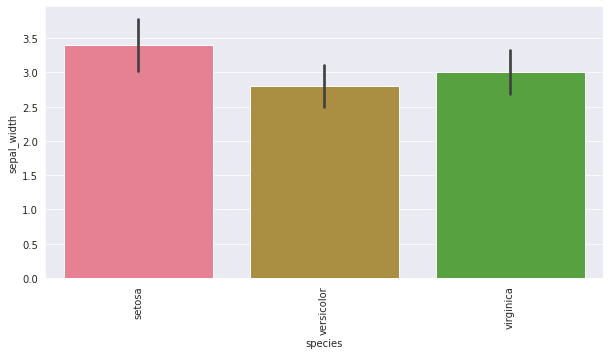

In [16]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_iris,
                 x="species",
                 y="sepal_width",
                 estimator=np.median,
                 #errorbar en versiones mas recientes
                 ci='sd')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=90)
plt.show()

In [8]:
### Crearemos nuevas columnas utilizando List Comprehension 
labels_dict = {
    'setosa' : '1',
    'versicolor' : '2',
    'virginica' : '0'
}

groups = [df_iris_by_species.get_group(x) for x in df_iris_by_species.groups]
scipy.stats.levene(groups[0].sepal_width, groups[1].sepal_width, groups[2].sepal_width, center='median')


LeveneResult(statistic=0.5902115655853319, pvalue=0.5555178984739075)


    Mediana (linea gruesa)
    Caja (Cuantiles 25% y 75%)
    Bigotes (intervalo de confianza del 95%)
    Puntos Outlayers


Las varianzas son iguales, ya que el valor p es 0,556 (mayor que 0,05).

Este conjunto de datos satisface nuestros supuestos, por lo que podemos ejecutar el ANOVA.

#### ANOVA


El ANOVA compara medias entre grupos, lo principal es la comparación entre los cuadrados de los residuales intergrupos, y los residuales intragrupos, los primeros son los cuadrados de la diferencia entre las medias de todas las observaciones y las medias de cada grupo al cuadrado multiplicado por el número de observaciones totales.

los residuales intra grupos son la diferencia entre cada observación xi,g
del grupo g y las medias del grupo respectivo

In [9]:
f_value, p_value = scipy.stats.f_oneway(groups[0][['sepal_width']],
                                  groups[1][['sepal_width']],
                                  groups[2][['sepal_width']])

print("Resultados ANOVA:\n F: ",f_value, "\n p: " + str(p_value))

Resultados ANOVA:
 F:  [49.16004009] 
 p: [4.49201713e-17]


In [10]:
f_value

array([49.16004009])

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
'''
lm = ols(formula='sepal_width ~ species', data=df_iris)

# fit model to data to obtain parameter estimates
results = lm.fit()

# print summary of linear regression
print(my_model_fit.summary())
'''

lm = ols(formula="sepal_width ~ species", data=df_iris).fit()
results = sm.stats.anova_lm(lm)


In [12]:
print(results)

             df     sum_sq   mean_sq         F        PR(>F)
species     2.0  11.344933  5.672467  49.16004  4.492017e-17
Residual  147.0  16.962000  0.115388       NaN           NaN


In [13]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:            sepal_width   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     49.16
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           4.49e-17
Time:                        13:34:47   Log-Likelihood:                -49.366
No. Observations:                 150   AIC:                             104.7
Df Residuals:                     147   BIC:                             113.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.42

In [14]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df_iris['sepal_width'], groups=df_iris['species'], alpha = 0.05)
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    setosa versicolor   -0.658  0.001 -0.8189 -0.4971   True
    setosa  virginica   -0.454  0.001 -0.6149 -0.2931   True
versicolor  virginica    0.204 0.0088  0.0431  0.3649   True
------------------------------------------------------------


Como el valor de p es muy pequeño, rechazamos la hipotésis nula.
Por lo tanto la anchura de pétalo es significativamente diferente entre ambos grupos. 